# Imports

In [3]:
cd ../

/Users/gray/projects/connections-ai


In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import random
from puzzle import ConnectionsPuzzle
import json
import seaborn as sns
import scipy
# from scipy.stats import pearsonr
from pprint import pprint

# Visualization functions

## Visualize success of each color + overall

In [5]:
def plot_success_rate(exp_name_df_dict):
    """
    Plot a bar chart for the success rate of each color and overall success rate for given experiments.

    :param exp_name_df_dict: Dict where keys are experiment names, and values are dataframes with experiment data
    """
    # Initialize a matplotlib subplot with 1 row and as many columns as there are experiments
    fig, ax = plt.subplots(figsize=(14, 7))

    # Set the width of a single bar
    bar_width = 0.1

    # Initialize an index for the x-axis
    r = np.arange(len(exp_name_df_dict.items()))

    # Define the colors using hex color codes
    colors = ['#fbd400', '#69e352', '#5492ff', '#df7bea', '#A9A9A9']  # Yellow, Green, Blue, Purple, Grey
    exp_names = []

    # Loop through each dataframe and calculate the success rate for each color and overall
    for idx, (exp_name, df) in enumerate(exp_name_df_dict.items()):
        exp_names.append(exp_name)
        # Calculate success rates
        success_yellow = df['solved_yellow'].mean()
        success_green = df['solved_green'].mean()
        success_blue = df['solved_blue'].mean()
        success_purple = df['solved_purple'].mean()
        success_overall = df['solved_overall'].mean()

        # Create a list of these success rates
        success_rates = [success_yellow, success_green, success_blue, success_purple, success_overall]

        # Plot each bar for the current experiment
        for i, (success_rate, color) in enumerate(zip(success_rates, colors)):
            bars = ax.bar(r[idx] + i * bar_width, success_rate, color=color, width=bar_width, edgecolor=color)
            # Add the text label above each bar
            for bar in bars:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{success_rate:.2f}',
                        ha='center', va='bottom')

    # Add labels, title, and legend
    ax.set_xlabel('Experiments', fontweight='bold')
    ax.set_xticks(r + bar_width * (len(success_rates) - 1) / 2)
    ax.set_xticklabels(exp_names)
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate by Color and Overall for Each Experiment')
    ax.set_ylim(0, 1)

    # Create legend & Show graphic
    plt.legend(['Yellow', 'Green', 'Blue', 'Purple', 'Overall'], loc='upper left')
    plt.show()

def plot_avg_success_rate(experiment_files: dict) -> dict:
    """
    Load and average the dataframes for each experiment across multiple runs.

    :param experiment_files: Dictionary with keys as experiment names and values as a list of file paths to json files.
    """
    averaged_dataframes_dict = {}
    
    for experiment_name, file_paths in experiment_files.items():
        # Load all dataframes for this experiment
        dataframes = [pd.read_json(file_path) for file_path in file_paths]

        # Combine the dataframes by concatenating them along the rows
        combined_dataframe = pd.concat(dataframes, ignore_index=True)

        # Calculate the mean for each column that needs to be averaged
        mean_columns = ['solved_yellow', 'solved_green', 'solved_blue', 'solved_purple', 'solved_overall']
        averaged_dataframe = combined_dataframe[mean_columns].mean(axis=0).to_frame().T

        # Add the averaged dataframe to the dictionary with the experiment name as the key
        averaged_dataframes_dict[experiment_name] = averaged_dataframe

    plot_success_rate(averaged_dataframes_dict)


def process_puzzles_solved_llm(json_path):
    df = pd.read_json(json_path)
    num_seeds = len(np.unique(df['seed']))
    # Calculate success rates
    success_yellow_count = (df['solved_yellow'] == True).sum() / 750
    success_green_count = (df['solved_green'] == True).sum() / 750
    success_blue_count = (df['solved_blue'] == True).sum() / 750
    success_purple_count = (df['solved_purple'] == True).sum() / 750
    success_overall_count = (df['solved_overall'] == True).sum() / 750

    # count_list = [success_yellow_count, success_green_count, success_blue_count, success_purple_count, success_overall_count]
    # count_list = [ct / num_seeds for ct in count_list]
    return [success_yellow_count, success_green_count, success_blue_count, success_purple_count, success_overall_count]

def process_puzzles_solved_emb(json_path):
    df = pd.read_json(json_path)
    df['yellow_solved_in_5'] = df['yellow_solved_at'] < 5
    df['green_solved_in_5'] = df['green_solved_at'] < 5

    df['blue_solved_in_5'] = df['blue_solved_at'] < 5
    df['purple_solved_in_5'] = df['purple_solved_at'] < 5
    df['puzzle_solved_in_5'] = df['yellow_solved_in_5'] & df['green_solved_in_5'] & df['blue_solved_in_5'] & df['purple_solved_in_5']

    success_yellow_count = (df['yellow_solved_in_5'] == True).sum() / 250
    success_green_count = (df['green_solved_in_5'] == True).sum() / 250
    success_blue_count = (df['blue_solved_in_5'] == True).sum() / 250
    success_purple_count = (df['purple_solved_in_5'] == True).sum() / 250
    success_overall_count = (df['puzzle_solved_in_5'] == True).sum() / 250

    
    return [success_yellow_count, success_green_count, success_blue_count, success_purple_count, success_overall_count]

def plot_puzzles_solved(exp_name_json_dict):
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.1

    # Initialize an index for the x-axis
    r = np.arange(len(exp_name_json_dict.items()))

    
    # Define the colors using hex color codes
    colors = ['#fbd400', '#69e352', '#5492ff', '#df7bea', '#A9A9A9'] # Yellow, Green, Blue, Purple, Grey
    for idx, (exp_name, path) in enumerate(exp_name_json_dict.items()):
        if 'GPT' in path:
            solved_counts = process_puzzles_solved_llm(path)
        else:
            solved_counts = process_puzzles_solved_emb(path)

        for count, color in zip(solved_counts, colors):
            if color == "#A9A9A9":
                print(f"[{exp_name}] Overall: {count}")

        # Plot each bar for the current experiment
        for i, (solved_count, color) in enumerate(zip(solved_counts, colors)):
            bars = ax.bar(r[idx] + i * bar_width, solved_count, color=color, width=bar_width, edgecolor=color)
            # Add the text label above each bar
            # for bar in bars:
            #     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{solved_count:.2f}',
            #             ha='center', va='bottom')
    
    # Add labels, title, and legend
    ax.set_xlabel('Model', fontweight='bold')
    ax.set_xticks(r + bar_width * (len(solved_counts) - 1) / 2)
    ax.set_xticklabels(exp_name_json_dict.keys())
    ax.set_ylabel('Average Success Rate', fontweight='bold')
    ax.set_title('Average Success Rate per Category by Model')
    ax.set_ylim(0, 1)

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    # Create legend & Show graphic
    plt.legend(['Yellow', 'Green', 'Blue', 'Purple', 'Overall'], loc='upper left')
    plt.show()


## Visualize puzzle_level metrics

In [6]:
# red_low_green_high_palette = sns.color_palette("blend:#f00,#0c0", as_cmap=True)
# green_low_red_high_palette = sns.color_palette("GnRd", as_cmap=True)
# RdYlGn

def calculate_puzzle_metrics_for_experiments(experiment_files_dict: dict) -> dict:
    """
    Calculate metrics for each puzzle based on multiple experiment runs for multiple experiments.
    
    :param experiment_files_dict: Dictionary with keys as experiment names and values as lists of file paths to json files.
    :return: Dictionary with keys as experiment names and values as DataFrames with metrics for each puzzle_id.
    """
    experiment_metrics = {}

    for experiment_name, file_list in experiment_files_dict.items():
        # Load all dataframes for the current experiment's runs
        dataframes = [pd.read_json(file_path) for file_path in file_list]
        
        # Combine all dataframes into one
        combined_df = pd.concat(dataframes, ignore_index=True)
        
        # Calculate the number of categories solved for each row
        combined_df['num_categories_solved'] = combined_df.apply(calculate_num_categories_solved, axis=1)

        # Group by 'puzzle_id' and calculate the required metrics for each puzzle
        puzzle_metrics = combined_df.groupby('puzzle_id').agg(
            average_success_rate=pd.NamedAgg(column='solved_overall', aggfunc='mean'),
            ever_solved=pd.NamedAgg(column='solved_overall', aggfunc=lambda x: any(x)),
            average_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='mean'),
            max_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='max'),
            min_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='min')
        ).reset_index()
        
        # Add the calculated metrics to the dictionary with the experiment name as the key
        experiment_metrics[experiment_name] = puzzle_metrics

    return experiment_metrics

def calculate_num_categories_solved(row):
    # Count the number of True values across the four categories
    return sum([row['solved_yellow'], row['solved_green'], row['solved_blue'], row['solved_purple']])


def plot_heatmaps(experiment_metrics: dict):
    """
    Generate two heatmap plots for multiple experiments based on their average success rate
    and whether each puzzle was ever solved or not.

    :param experiment_metrics: Dictionary with keys as experiment names and values as DataFrames containing metrics.
    """
    # Initialize matplotlib subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(30, 10))

    # DataFrames for average success rates and ever solved metrics
    success_rates_df = pd.DataFrame({name: metrics['average_success_rate'] for name, metrics in experiment_metrics.items()})
    ever_solved_df = pd.DataFrame({name: metrics['ever_solved'].astype(int) for name, metrics in experiment_metrics.items()})
    num_categories_solved_df = pd.DataFrame({name: metrics['average_categories_solved'] for name, metrics in experiment_metrics.items()})
    max_categories_solved_df = pd.DataFrame({name: metrics['max_categories_solved'] for name, metrics in experiment_metrics.items()})
    min_categories_solved_df = pd.DataFrame({name: metrics['min_categories_solved'] for name, metrics in experiment_metrics.items()})

    # Create heatmaps
    sns.heatmap(success_rates_df.T, ax=ax1, cmap="flare_r", cbar_kws={'label': 'Average Success Rate', 'shrink': 0.5})
    sns.heatmap(ever_solved_df.T, ax=ax2, cmap="flare_r", cbar_kws={'label': 'Ever Solved (1 or 0)', 'shrink': 0.5})
    sns.heatmap(num_categories_solved_df.T, ax=ax3, cmap="flare_r", cbar_kws={'label': 'Average Number of Categories Solved', 'shrink': 0.5})
    sns.heatmap(max_categories_solved_df.T, ax=ax4, cmap="flare_r", cbar_kws={'label': 'Max Number of Categories Solved', 'shrink': 0.5})
    sns.heatmap(min_categories_solved_df.T, ax=ax5, cmap="flare_r", cbar_kws={'label': 'Min Number of Categories Solved', 'shrink': 0.5})

    # Set the title for the heatmaps
    ax1.set_title('Average Success Rate per Puzzle')
    ax2.set_title('Puzzle Ever Solved')
    ax3.set_title('Average Number of Categories Solved')
    ax4.set_title('Max Number of Categories Solved')
    ax5.set_title('Min Number of Categories Solved')

    # Set axis labels
    ax1.set_xlabel('Puzzle ID')
    ax1.set_ylabel('Experiments')
    ax2.set_xlabel('Puzzle ID')
    ax2.set_ylabel('Experiments')
    ax3.set_xlabel('Puzzle ID')
    ax3.set_ylabel('Experiments')
    ax4.set_xlabel('Puzzle ID')
    ax4.set_ylabel('Experiments')
    ax5.set_xlabel('Puzzle ID')
    ax5.set_ylabel('Experiments')

    # Determine the range of puzzle IDs
    puzzle_ids = success_rates_df.index

    # Shift the x-ticks to align with the center of each column
    tick_positions = np.arange(len(puzzle_ids)) + 0.25  # Shift by half a column width
    # Set x-ticks for each heatmap
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(puzzle_ids, rotation=90, fontsize=8)  # Adjust fontsize if necessary

    # Rotate the y-axis labels for better readability
    plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax2.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax3.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax4.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax5.yaxis.get_majorticklabels(), rotation=0)


    # Adjust layout for better fit and show the plot
    plt.tight_layout()
    plt.show()


## Visualize number of invalid responses

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_and_plot_invalid_requests(experiment_files_dict: dict):
    experiment_averages = {}
    experiment_errors = {}

    for experiment_name, file_list in experiment_files_dict.items():
        all_invalid_counts = []

        # Load all dataframes for the current experiment's runs
        for file_path in file_list:
            df = pd.read_json(file_path)
            all_invalid_counts.extend(df['num_invalid'].tolist())

        # Calculate the average and SEM for num_invalid
        experiment_averages[experiment_name] = np.mean(all_invalid_counts)
        experiment_errors[experiment_name] = np.std(all_invalid_counts, ddof=1)

    # Create bar plot
    fig, ax = plt.subplots()
    ax.bar(experiment_averages.keys(), experiment_averages.values(), yerr=experiment_errors.values(), capsize=5)
    ax.set_xlabel('Experiment Name')
    ax.set_ylabel('Average Number of Invalid Requests')
    ax.set_title('Average Invalid Requests per Experiment')

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

def plot_grouped_histograms_invalid_requests(experiment_files_dict: dict):
    # Initialize a list to keep all counts for each experiment
    invalid_counts_per_experiment = []

    # Find the max invalid count across all experiments
    max_invalid = 0
    for file_list in experiment_files_dict.values():
        for file_path in file_list:
            df = pd.read_json(file_path)
            current_max = df['num_invalid'].max()
            if current_max > max_invalid:
                max_invalid = current_max

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Calculate the number of experiments to determine bar width
    num_experiments = len(experiment_files_dict)
    total_width = 0.8
    bar_width = total_width / num_experiments

    # Calculate the positions of each bar's left edge
    bar_positions = np.arange(1, max_invalid + 1) - (total_width / 2)

    # Iterate through each experiment and plot
    for i, (experiment_name, file_list) in enumerate(experiment_files_dict.items()):
        all_invalid_counts = []
        for file_path in file_list:
            df = pd.read_json(file_path)
            # Only consider entries with invalid requests greater than 0
            all_invalid_counts.extend(df[df['num_invalid'] > 0]['num_invalid'].tolist())

        # Count the frequency of each number of invalid requests
        counts = [all_invalid_counts.count(x) for x in range(1, max_invalid + 1)]

        # Calculate the bar positions for this experiment
        experiment_bar_positions = bar_positions + (i * bar_width)

        # Plot bars for this experiment
        plt.bar(experiment_bar_positions, counts, width=bar_width, label=experiment_name)

    # Set the position and labels for the x-ticks
    tick_positions = np.arange(1, max_invalid + 1)
    plt.xticks(tick_positions, tick_positions)

    # Adding labels and title
    plt.xlabel('Number of Invalid Requests')
    plt.ylabel('Frequency')
    plt.title('Grouped Histogram of Invalid Requests per Experiment (Excluding 0)')
    plt.legend(title="Experiments")

    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_any_invalid_requests(experiment_files_dict: dict):
    plt.figure(figsize=(8, 4))

    # Loop through each experiment and count puzzles with invalid requests
    for experiment_name, file_list in experiment_files_dict.items():
        total_invalid_puzzles = 0
        for file_path in file_list:
            df = pd.read_json(file_path)
            # Increment count if there are any invalid requests for a puzzle
            total_invalid_puzzles += (df['num_invalid'] > 0).sum()
        plt.bar(experiment_name, total_invalid_puzzles)

    # Plotting
    plt.xlabel('Experiment Name')
    plt.ylabel('Number of Puzzles with Invalid Requests')
    plt.title('Count of Puzzles with Invalid Requests per Experiment')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()

# Example usage:
# calculate_and_plot_invalid_requests(experiment_files_dict)


## Calculate puzzle difficulty



In [8]:
def calc_puzzle_difficulty(experiment_files_dict: dict):
    # Get the metrics for each puzzle across all experiments
    experiment_metrics = calculate_puzzle_metrics_for_experiments(experiment_files_dict)
    
    # Concatenate the average categories solved for each experiment into a single DataFrame
    categories_solved = pd.concat([metrics['average_categories_solved'] for metrics in experiment_metrics.values()], axis=1)
    
    # Calculate the mean of the average categories solved across all experiments for each puzzle
    categories_solved['mean_categories_solved'] = categories_solved.mean(axis=1)
    
    # Normalize the mean categories solved to a 0-1 scale
    min_categories_solved = categories_solved['mean_categories_solved'].min()
    max_categories_solved = categories_solved['mean_categories_solved'].max()
    categories_solved['normalized_categories_solved'] = (
        categories_solved['mean_categories_solved'] - min_categories_solved
    ) / (max_categories_solved - min_categories_solved)
    
    # Calculate the difficulty score for each puzzle
    categories_solved['difficulty_score'] = 1 - categories_solved['normalized_categories_solved']
    
    # Sort the puzzles by difficulty score in descending order
    # difficulty_scores = categories_solved['difficulty_score'].sort_values(ascending=False)
    difficulty_scores = categories_solved['difficulty_score']

    return difficulty_scores

def plot_difficulty_score_heatmaps(experiment_metrics: dict, real_difficulty_scores: list):
    # Concatenate the average categories solved for each experiment into a single DataFrame
    all_avg_categories_solved = pd.concat([metrics['average_categories_solved'] for metrics in experiment_metrics.values()], axis=0)
    # Normalize the mean categories solved to a 0-1 scale
    min_categories_solved = all_avg_categories_solved.min()
    max_categories_solved = all_avg_categories_solved.max()

    # Compute the difficulty score for each puzzle in each experiment
    for experiment_name, metrics in experiment_metrics.items():
        metrics['difficulty_score'] = 1 - (metrics['average_categories_solved'] - min_categories_solved) / (max_categories_solved - min_categories_solved)

    # Compute the average difficulty score across all experiments for each puzzle
    all_difficulty_scores = pd.concat([metrics[['puzzle_id', 'difficulty_score']] for metrics in experiment_metrics.values()])
    average_difficulty_scores = all_difficulty_scores.groupby('puzzle_id')['difficulty_score'].mean().reset_index()
    print(f'min all norm diffs: {average_difficulty_scores["difficulty_score"].min()}')
    print(f'max all norm diffs: {average_difficulty_scores["difficulty_score"].max()}')
    # Prepare data for plotting
    difficulty_scores_df = pd.DataFrame({
        experiment_name: metrics.set_index('puzzle_id')['difficulty_score'] for experiment_name, metrics in experiment_metrics.items()
    })
    difficulty_scores_df['Average'] = average_difficulty_scores.set_index('puzzle_id')
    difficulty_scores_df['Real Difficulty Score'] = real_difficulty_scores

    # Adjusting the plot size and ticks for better visibility of 250 puzzles
    plt.figure(figsize=(50, 4))  # Adjusted width for visibility
    sns.heatmap(difficulty_scores_df.T, cmap="viridis", annot=False, cbar_kws={'label': 'Difficulty Score'})
    plt.title('Difficulty Scores per Puzzle')
    plt.xlabel('Puzzle ID')
    plt.ylabel('Experiments / Average / Real Score')
    
    puzzle_ids = np.arange(1, len(real_difficulty_scores) + 1)
    # Customizing x-ticks to center under each heatmap column
    tick_positions = np.arange(len(puzzle_ids)) + 0.25  # Centered positions for each puzzle ID
    plt.xticks(tick_positions, puzzle_ids, rotation=90, fontsize=8)  # Adjust fontsize as needed for readability

    plt.tight_layout()
    plt.show()
    
def plot_difficulty_score_heatmaps2(experiment_metrics: dict, real_difficulty_scores: list, score_calculation_method='avg'):
    """
    Generate heatmap plots for multiple experiments based on their difficulty scores,
    which can be calculated using the average, maximum, or minimum categories solved.

    :param experiment_metrics: Dictionary with keys as experiment names and values as DataFrames containing metrics.
    :param real_difficulty_scores: List of real difficulty scores for comparison.
    :param score_calculation_method: Method to calculate difficulty score ('avg', 'max', 'min').
    """
    # Define the column to use based on the score_calculation_method
    if score_calculation_method == 'avg':
        column_name = 'average_categories_solved'
    elif score_calculation_method == 'max':
        column_name = 'max_categories_solved'
    elif score_calculation_method == 'min':
        column_name = 'min_categories_solved'
    else:
        raise ValueError("score_calculation_method must be 'avg', 'max', or 'min'.")

    # Concatenate the selected categories solved for each experiment into a single DataFrame
    all_categories_solved = pd.concat([metrics[column_name] for metrics in experiment_metrics.values()], axis=0)
    # Normalize the selected categories solved to a 0-1 scale
    min_categories_solved = all_categories_solved.min()
    max_categories_solved = all_categories_solved.max()

    # Compute the difficulty score for each puzzle in each experiment
    for experiment_name, metrics in experiment_metrics.items():
        metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)

    # Compute the average difficulty score across all experiments for each puzzle
    all_difficulty_scores = pd.concat([metrics[['puzzle_id', 'difficulty_score']] for metrics in experiment_metrics.values()])
    average_difficulty_scores = all_difficulty_scores.groupby('puzzle_id')['difficulty_score'].mean().reset_index()

    # Prepare data for plotting
    difficulty_scores_df = pd.DataFrame({
        experiment_name: metrics.set_index('puzzle_id')['difficulty_score'] for experiment_name, metrics in experiment_metrics.items()
    })
    difficulty_scores_df['Average'] = average_difficulty_scores.set_index('puzzle_id')
    difficulty_scores_df['Real Difficulty Score'] = real_difficulty_scores

    # Plotting
    plt.figure(figsize=(50, 4))  # Adjusted width for visibility
    sns.heatmap(difficulty_scores_df.T, cmap="RdYlGn_r", annot=False, cbar_kws={'label': 'Difficulty Score'})
    plt.title(f'Difficulty Scores per Puzzle (Method: {score_calculation_method.capitalize()})')
    plt.xlabel('Puzzle ID')
    plt.ylabel('Experiments / Average / Real Score')

    puzzle_ids = np.arange(1, len(real_difficulty_scores) + 1)
    # Customizing x-ticks to center under each heatmap column
    tick_positions = np.arange(len(puzzle_ids)) + 0.25  # Centered positions for each puzzle ID
    plt.xticks(tick_positions, puzzle_ids, rotation=90, fontsize=8)  # Adjust fontsize as needed for readability

    plt.tight_layout()
    plt.show()

def get_real_puzzle_difficulty():
    puzzle_file = 'data/puzzle_data.json'
    with open(puzzle_file) as f:
        puzzle_data = json.load(f)
    
    nyt_difficulties = [puzzle['difficulty'] for puzzle in puzzle_data]
    nyt_difficulties = [0 if x is None else x for x in nyt_difficulties]
    return nyt_difficulties

def normalize_real_puzzle_difficulty(nyt_difficulties):
    # Removing the missing values (0s) from the list for normalization process
    filtered_scores = [score for score in nyt_difficulties if score != 0]

    # Calculating the minimum and maximum of the filtered (non-zero) scores
    min_score = min(filtered_scores)
    max_score = max(filtered_scores)

    normalized_scores = [(score - min_score) / (max_score - min_score) if score != 0 else 0 for score in nyt_difficulties]

    return normalized_scores
    

## Variance Analysis

In [9]:
def calculate_experiment_variability(experiment_files_dict):
    variability_summary = {}
    for experiment_name, file_list in experiment_files_dict.items():
        # Load all dataframes for the current experiment's runs
        dataframes = [pd.read_json(file_path) for file_path in file_list]
        
        # Combine all dataframes into one
        combined_df = pd.concat(dataframes, ignore_index=True)
        
        # Calculate the number of categories solved for each row
        combined_df['num_categories_solved'] = combined_df.apply(calculate_num_categories_solved, axis=1)

        # Assuming 'num_categories_solved' is already computed
        # Calculate variability (e.g., standard deviation) for each puzzle
        puzzle_variability = combined_df.groupby('puzzle_id')['num_categories_solved'].std()

        # Aggregate variability measures
        avg_variability = puzzle_variability.mean()
        median_variability = puzzle_variability.median()
        max_variability = puzzle_variability.max()

        # Store in summary
        variability_summary[experiment_name] = {
            'average_variability': avg_variability,
            'median_variability': median_variability,
            'max_variability': max_variability
        }

    return variability_summary

## Calculate correlations

In [10]:
def filter_puzzles(experiment_metrics, start_id):
    """
    Filters the dataframes in the experiment_metrics dictionary to include only puzzles within a specified range.

    :param experiment_metrics: Dictionary with experiment names as keys and DataFrames as values.
    :param start_id: The starting puzzle ID for the filter range.
    :param end_id: The ending puzzle ID for the filter range.
    :return: A new dictionary with the filtered DataFrames.
    """
    filtered_metrics = {}
    for experiment_name, metrics_df in experiment_metrics.items():
        # Filter the DataFrame to include only the specified puzzle IDs
        filtered_df = metrics_df[(metrics_df['puzzle_id'] >= start_id)]
        filtered_metrics[experiment_name] = filtered_df
    return filtered_metrics

def calculate_difficulty_correlation(experiment_metrics: dict, real_difficulty_scores: list):
    puzzle_ids = np.arange(127, 251)
    all_metrics_df = pd.DataFrame({
        "puzzle_id": puzzle_ids,
        "real_difficulty_score": real_difficulty_scores
    })

    all_avg_categories_solved = pd.concat([metrics['average_categories_solved'] for metrics in experiment_metrics.values()], axis=0)
    # Normalize the mean categories solved to a 0-1 scale
    min_categories_solved = all_avg_categories_solved.min()
    max_categories_solved = all_avg_categories_solved.max()

    # Compute the difficulty score for each puzzle in each experiment
    for experiment_name, metrics in experiment_metrics.items():
        metrics['difficulty_score'] = 1 - (metrics['average_categories_solved'] - min_categories_solved) / (max_categories_solved - min_categories_solved)

    # Compute the average difficulty score across all experiments for each puzzle
    all_difficulty_scores = pd.concat([metrics[['puzzle_id', 'difficulty_score']] for metrics in experiment_metrics.values()])
    average_difficulty_scores = all_difficulty_scores.groupby('puzzle_id')['difficulty_score'].mean().reset_index()
    # Re-aggregate metrics
    for experiment_name, metrics in experiment_metrics.items():
        print(experiment_name)
        print(len(metrics))
        all_metrics_df[f"{experiment_name}_difficulty_score"] = metrics.set_index('puzzle_id')['difficulty_score'].values
        all_metrics_df[f"{experiment_name}_avg_success_rate"] = metrics.set_index('puzzle_id')['average_success_rate'].values
        all_metrics_df[f"{experiment_name}_ever_solved"] = metrics.set_index('puzzle_id')['ever_solved'].values
        all_metrics_df[f"{experiment_name}_avg_categories_solved"] = metrics.set_index('puzzle_id')['average_categories_solved'].values

    # Recalculate correlations with corrected data
    correlation_results_corrected = all_metrics_df.corr(method='pearson')  # Pearson's correlation

    # Extract correlations with real_difficulty_score
    correlations_with_real_difficulty_corrected = correlation_results_corrected['real_difficulty_score'].drop(['real_difficulty_score', 'puzzle_id'])
    return correlations_with_real_difficulty_corrected

def calculate_difficulty_correlation2(experiment_metrics: dict, real_difficulty_scores: list):
    puzzle_ids = np.arange(127, 251)
    all_metrics_df = pd.DataFrame({
        "puzzle_id": puzzle_ids,
        "real_difficulty_score": real_difficulty_scores
    })

    
    # Re-aggregate metrics
    for experiment_name, metrics in experiment_metrics.items():
        print(experiment_name)
        all_metrics_df[f"{experiment_name}_avg_success_rate"] = metrics.set_index('puzzle_id')['average_success_rate'].values
        all_metrics_df[f"{experiment_name}_ever_solved"] = metrics.set_index('puzzle_id')['ever_solved'].values
        all_metrics_df[f"{experiment_name}_avg_categories_solved"] = metrics.set_index('puzzle_id')['average_categories_solved'].values
        all_metrics_df[f"{experiment_name}_max_categories_solved"] = metrics.set_index('puzzle_id')['max_categories_solved'].values
        all_metrics_df[f"{experiment_name}_min_categories_solved"] = metrics.set_index('puzzle_id')['min_categories_solved'].values


    # Recalculate correlations with corrected data
    correlation_results = all_metrics_df.corr(method='pearson')  # Pearson's correlation

    # Extract correlations with real_difficulty_score
    correlations_with_real_difficulty = correlation_results['real_difficulty_score'].drop(['real_difficulty_score', 'puzzle_id'])
    return correlations_with_real_difficulty


def calculate_difficulty_corr_llm_and_emb(exp_name_json_dict, real_difficulty_scores: list):
    puzzle_ids = np.arange(127, 251)
    all_metrics_df = pd.DataFrame({
        "puzzle_id": puzzle_ids,
        "real_difficulty_score": real_difficulty_scores
    })

    
    # Define the colors using hex color codes
    for experiment_name, path in exp_name_json_dict.items():
        if 'GPT' in path:
            solved_counts = process_puzzles_solved_llm(path)
        else:
            solved_counts = process_puzzles_solved_emb(path)

        df = pd.read_json(path)
        puzzle_metrics = df.groupby('puzzle_id').agg(
            average_success_rate=pd.NamedAgg(column='solved_overall', aggfunc='mean'),
            ever_solved=pd.NamedAgg(column='solved_overall', aggfunc=lambda x: any(x)),
            average_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='mean'),
            max_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='max'),
            min_categories_solved=pd.NamedAgg(column='num_categories_solved', aggfunc='min')
        ).reset_index()
        
        # Add the calculated metrics to the dictionary with the experiment name as the key
        experiment_metrics[experiment_name] = puzzle_metrics
        # Plot each bar for the current experiment
        for i, (solved_count, color) in enumerate(zip(solved_counts, colors)):
            bars = ax.bar(r[idx] + i * bar_width, solved_count, color=color, width=bar_width, edgecolor=color)
            # Add the text label above each bar
            # for bar in bars:
            #     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{solved_count:.2f}',
            #             ha='center', va='bottom')
    
    # Add labels, title, and legend
    ax.set_xlabel('Model', fontweight='bold')
    ax.set_xticks(r + bar_width * (len(solved_counts) - 1) / 2)
    ax.set_xticklabels(exp_name_json_dict.keys())
    ax.set_ylabel('Average Success Rate', fontweight='bold')
    ax.set_title('Average Success Rate per Category by Model')
    ax.set_ylim(0, 1)

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    # Create legend & Show graphic
    plt.legend(['Yellow', 'Green', 'Blue', 'Purple', 'Overall'], loc='upper left')
    plt.show()

## 3/4 correct analysis


In [16]:
def is_first_guess_correct(row):
    if not row['guesses']:
        return False
    return row['guess_accuracy'][0] == 'CORRECT'
def is_first_guess_incorrect(row):
    if not row['guesses']:
        return False
    return row['guess_accuracy'][0] == 'INCORRECT'
def is_first_guess_nearly_correct(row):
    if not row['guesses']:
        return False
    return row['guess_accuracy'][0] == 'NEARLY_CORRECT'

def nearly_correct_rabbithole_2(row):
    if not row['guesses']:
        return False
    if len(row['guesses']) < 2:
        return False
    first_guess_set = set(row['guesses'][0])
    second_guess_set = set(row['guesses'][1])
    return (len(first_guess_set.intersection(second_guess_set)) >= 3) and (row['first_nearly_correct'])

def nearly_correct_rabbithole_3(row):
    if not row['guesses']:
        return False
    if len(row['guesses']) < 3:
        return False
    second_guess_set = set(row['guesses'][1])
    third_guess_set = set(row['guesses'][2])
    return (len(second_guess_set.intersection(third_guess_set)) >= 3) and (row['nearly_correct_rabbithole_2'])

def nearly_correct_rabbithole_4(row):
    if not row['guesses']:
        return False
    if len(row['guesses']) < 4:
        return False
    second_guess_set = set(row['guesses'][2])
    third_guess_set = set(row['guesses'][3])
    return (len(second_guess_set.intersection(third_guess_set)) >= 3) and (row['nearly_correct_rabbithole_3'])

def nearly_correct_rabbithole_5(row):
    if not row['guesses']:
        return False
    if len(row['guesses']) < 5:
        return False
    second_guess_set = set(row['guesses'][3])
    third_guess_set = set(row['guesses'][4])
    return (len(second_guess_set.intersection(third_guess_set)) >= 3) and (row['nearly_correct_rabbithole_4'])

    # return row['guess_accuracy'][0] == 'NEARLY_CORRECT'
    # first_guess = set(row['guesses'][0])

    # # new data
    # if 'id' in row['puzzle_data']:
    #     for group in row['puzzle_data']['answers']:
    #         correct_words = set(group['words'])
    #         if len(first_guess.intersection(correct_words)) == 3 and len(correct_words) == 4:
    #             return True
    # # old data
    # else:
    #     for group in row['puzzle_data']:
    #         correct_words = set(group['words'])
    #         if len(first_guess.intersection(correct_words)) == 3 and len(correct_words) == 4:
    #             return True
    # return False

def shares_three_words_with_first(row):
    if len(row['guesses']) < 2 or not row['nearly_correct']:
        # If there's no second guess or the first guess wasn't nearly correct, this condition cannot be met
        return False
    
    first_guess = set(row['guesses'][0])
    second_guess = set(row['guesses'][1])
    return len(first_guess.intersection(second_guess)) == 3

def classify_guess_accuracy(row):
    accuracy_list = []
    if not row['guesses']:
        return accuracy_list
    # new data
    if 'id' in row['puzzle_data']:
        for guess in row['guesses']:
            guess_set = set(guess)
            max_overlap = 0
            for category in row['puzzle_data']['answers']:
                correct_words = set(category['words'])
                overlap = guess_set.intersection(set(correct_words))
                if len(overlap) > max_overlap:
                    max_overlap = len(overlap)
            if max_overlap == 4:
                accuracy_list.append('CORRECT')
            elif max_overlap == 3:
                accuracy_list.append('NEARLY_CORRECT')
            else:
                accuracy_list.append('INCORRECT')
    # old data
    else:
        for guess in row['guesses']:
            guess_set = set(guess)
            max_overlap = 0
            for category in row['puzzle_data']:
                correct_words = set(category['words'])
                overlap = guess_set.intersection(set(correct_words))
                if len(overlap) > max_overlap:
                    max_overlap = len(overlap)
            if max_overlap == 4:
                accuracy_list.append('CORRECT')
            elif max_overlap == 3:
                accuracy_list.append('NEARLY_CORRECT')
            else:
                accuracy_list.append('INCORRECT')
    return accuracy_list

# Analysis logic
def nearly_correct_analysis(experiment_files_dict):
    nearly_correct_metrics = {}
    new_dfs = {}
    for experiment_name, file_list in experiment_files_dict.items():
        # Load all dataframes for the current experiment's runs
        dataframes = [pd.read_json(file_path) for file_path in file_list]
        
        # Combine all dataframes into one
        df = pd.concat(dataframes, ignore_index=True)
        df['guess_accuracy'] = df.apply(classify_guess_accuracy, axis=1)
        df['first_correct'] = df.apply(is_first_guess_correct, axis=1)
        df['first_incorrect'] = df.apply(is_first_guess_incorrect, axis=1)
        df['first_nearly_correct'] = df.apply(is_first_guess_nearly_correct, axis=1)
        df['nearly_correct_rabbithole_2'] = df.apply(nearly_correct_rabbithole_2, axis=1)
        df['nearly_correct_rabbithole_3'] = df.apply(nearly_correct_rabbithole_3, axis=1)
        df['nearly_correct_rabbithole_4'] = df.apply(nearly_correct_rabbithole_4, axis=1)
        df['nearly_correct_rabbithole_5'] = df.apply(nearly_correct_rabbithole_5, axis=1)

        df[['puzzle_data', 'guess_accuracy', 'first_nearly_correct']]

        num_first_nearly_correct =  len(df[df['first_nearly_correct'] == True])
        num_first_correct =  len(df[df['first_correct'] == True])
        num_first_incorrect =  len(df[df['first_incorrect'] == True])
        num_first_not_nearly_correct =  len(df) - num_first_nearly_correct
        # Overall solved percentage
        overall_solved_percentage = df['solved_overall'].sum() / len(df)

        # Solved percentage where nearly_correct = True
        nearly_correct_solved_percentage = (df[df['first_nearly_correct'] == True]['solved_overall'].sum() / num_first_nearly_correct) if num_first_nearly_correct > 0 else 0
        # Solved percentage where correct = True
        correct_solved_percentage = (df[df['first_correct'] == True]['solved_overall'].sum() / num_first_correct) if num_first_correct > 0 else 0
        # Solved percentage where incorrect = True
        incorrect_solved_percentage = (df[df['first_incorrect'] == True]['solved_overall'].sum() / num_first_incorrect) if num_first_incorrect > 0 else 0

        # percentage of the time gpt goes down a rabbithole trying to fix the incorrect word
        num_nearly_correct_rabbithole_2 = df['nearly_correct_rabbithole_2'].sum()
        percent_nearly_correct_rabbithole_2_solved = (df[df['nearly_correct_rabbithole_2'] == True]['solved_overall'].sum() / num_nearly_correct_rabbithole_2)

        num_nearly_correct_rabbithole_3 = df['nearly_correct_rabbithole_3'].sum()
        percent_nearly_correct_rabbithole_3_solved = (df[df['nearly_correct_rabbithole_3'] == True]['solved_overall'].sum() / num_nearly_correct_rabbithole_3)

        num_nearly_correct_rabbithole_4 = df['nearly_correct_rabbithole_4'].sum()
        percent_nearly_correct_rabbithole_4_solved = (df[df['nearly_correct_rabbithole_4'] == True]['solved_overall'].sum() / num_nearly_correct_rabbithole_4)

        num_nearly_correct_rabbithole_5 = df['nearly_correct_rabbithole_5'].sum()
        percent_nearly_correct_rabbithole_5_solved = (df[df['nearly_correct_rabbithole_5'] == True]['solved_overall'].sum() / num_nearly_correct_rabbithole_5)
        # Solved percentage where nearly_correct = False
        not_nearly_correct_solved_percentage = (df[df['first_nearly_correct'] == False]['solved_overall'].sum() / num_first_not_nearly_correct) if num_first_not_nearly_correct > 0 else 0

        nearly_correct_metrics[experiment_name] = {
            'num_first_correct': num_first_correct,
            'num_first_nearly_correct': num_first_nearly_correct,
            'num_first_incorrect': num_first_incorrect,
            'num_2_rabbithole': num_nearly_correct_rabbithole_2,
            'num_3_rabbithole': num_nearly_correct_rabbithole_3,
            'num_4_rabbithole': num_nearly_correct_rabbithole_4,
            'num_5_rabbithole': num_nearly_correct_rabbithole_5,
            # 'num_first_not_nearly_correct': num_first_not_nearly_correct,
            'overall_percent_solved': overall_solved_percentage,
            'percent_solved_first_correct': correct_solved_percentage,
            'percent_solved_first_nearly_correct': nearly_correct_solved_percentage,
            'percent_solved_first_incorrect': incorrect_solved_percentage,
            'percent_2_rabbithole_correct': percent_nearly_correct_rabbithole_2_solved,
            'percent_3_rabbithole_correct': percent_nearly_correct_rabbithole_3_solved,
            'percent_4_rabbithole_correct': percent_nearly_correct_rabbithole_4_solved,
            'percent_5_rabbithole_correct': percent_nearly_correct_rabbithole_5_solved,
            # 'percent_solved_first_NOT_nearly_correct': not_nearly_correct_solved_percentage
        }

        new_dfs[experiment_name] = df

    return nearly_correct_metrics, new_dfs

In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
df = pd.read_json('results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json')
        
# Combine all dataframes into one
df['guess_accuracy'] = df.apply(classify_guess_accuracy, axis=1)
df['first_correct'] = df.apply(is_first_guess_correct, axis=1)
df['first_incorrect'] = df.apply(is_first_guess_incorrect, axis=1)
df['first_nearly_correct'] = df.apply(is_first_guess_nearly_correct, axis=1)
df['nearly_correct_rabbithole_2'] = df.apply(nearly_correct_rabbithole_2, axis=1)
df['nearly_correct_rabbithole_3'] = df.apply(nearly_correct_rabbithole_3, axis=1)
# display(df.head)
# display(df[df['first_nearly_correct'] == True])

In [24]:
difficulty_dict = {
    # 'BERT': '../results/SentenceTransformerBaseline_model-bert-base-nli-mean-tokens_results.json',
    # 'RoBERTa': '../results/SentenceTransformerBaseline_model-all-roberta-large-v1_results.json',
    # 'MiniLM': '../results/SentenceTransformerBaseline_model-all-MiniLM-L6-v2_results.json',
    # 'MPNet': '../results/SentenceTransformerBaseline_model-all-mpnet-base-v2_results.json',
    'GPT 3.5': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json'],
    # 'GPT 3.5 (CoT) ': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-True_results.json'],
    'GPT 4': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json'],
    'GPT 4 (CoT)': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-True_results.json'],
}

In [25]:
metric_dict, df_dict = nearly_correct_analysis(difficulty_dict)
pprint(metric_dict)

{'GPT 3.5': {'num_2_rabbithole': 59,
             'num_3_rabbithole': 40,
             'num_4_rabbithole': 30,
             'num_5_rabbithole': 24,
             'num_first_correct': 194,
             'num_first_incorrect': 258,
             'num_first_nearly_correct': 292,
             'overall_percent_solved': 0.0642570281124498,
             'percent_2_rabbithole_correct': 0.03389830508474576,
             'percent_3_rabbithole_correct': 0.0,
             'percent_4_rabbithole_correct': 0.0,
             'percent_5_rabbithole_correct': 0.0,
             'percent_solved_first_correct': 0.15979381443298968,
             'percent_solved_first_incorrect': 0.011627906976744186,
             'percent_solved_first_nearly_correct': 0.04794520547945205},
 'GPT 4': {'num_2_rabbithole': 234,
           'num_3_rabbithole': 168,
           'num_4_rabbithole': 136,
           'num_5_rabbithole': 112,
           'num_first_correct': 354,
           'num_first_incorrect': 125,
           'num_first_

### Significance Testing for Initial Guess Effect

In [29]:
for model, df in df_dict.items():
    solved_overall = np.array(df['solved_overall'], dtype=int)
    solved_if_first_correct = np.array(df[df['first_correct'] == True]['solved_overall'], dtype=int)
    solved_if_first_not_correct = np.array(df[df['first_nearly_correct'] == False]['solved_overall'], dtype=int)

    solved_if_first_incorrect = np.array(df[df['first_incorrect'] == True]['solved_overall'], dtype=int)
    solved_if_first_not_incorrect = np.array(df[df['first_incorrect'] == False]['solved_overall'], dtype=int)

    solved_if_first_nearly_correct = np.array(df[df['first_nearly_correct'] == True]['solved_overall'], dtype=int)
    solved_if_first_not_nearly_correct = np.array(df[df['first_nearly_correct'] == False]['solved_overall'], dtype=int)

    t, p = scipy.stats.ttest_ind(solved_overall, solved_if_first_nearly_correct, equal_var=False)
    print("\n\n")
    print(f"[{model}] Overall vs. Nearly Correct: t = {t}, p = {p}")

    t, p = scipy.stats.ttest_ind(solved_overall, solved_if_first_correct, equal_var=False)
    print(f"[{model}] Overall vs. Correct: t = {t}, p = {p}")

    t, p = scipy.stats.ttest_ind(solved_overall, solved_if_first_incorrect, equal_var=False)
    print(f"[{model}] Overall vs. Incorrect: t = {t}, p = {p}")

    # print("\n")

    # t, p = scipy.stats.ttest_ind(solved_if_first_nearly_correct, solved_if_first_not_nearly_correct, equal_var=False)
    # print(f"[{model}] Nearly Correct vs. Not Nearly Correct: t = {t}, p = {p}")

    # t, p = scipy.stats.ttest_ind(solved_if_first_correct, solved_if_first_not_correct, equal_var=False)
    # print(f"[{model}] Correct vs. Not Correct: t = {t}, p = {p}")

    # t, p = scipy.stats.ttest_ind(solved_if_first_incorrect, solved_if_first_not_incorrect, equal_var=False)
    # print(f"[{model}] Incorrect vs. Not Incorrect: t = {t}, p = {p}")




[GPT 3.5] Overall vs. Nearly Correct: t = 1.0585370288302156, p = 0.290233392579191
[GPT 3.5] Overall vs. Correct: t = -3.429025075834566, p = 0.0007130851683370019
[GPT 3.5] Overall vs. Incorrect: t = 4.70129118688398, p = 2.9664485305086058e-06



[GPT 4] Overall vs. Nearly Correct: t = 5.792708761597155, p = 1.0983710857000486e-08
[GPT 4] Overall vs. Correct: t = -6.8104166684345975, p = 2.2568416114822782e-11
[GPT 4] Overall vs. Incorrect: t = 12.42928170021509, p = 1.8296762970904675e-31



[GPT 4 (CoT)] Overall vs. Nearly Correct: t = 5.007201038150995, p = 7.592514069219176e-07
[GPT 4 (CoT)] Overall vs. Correct: t = -6.134184266714774, p = 1.405476356545464e-09
[GPT 4 (CoT)] Overall vs. Incorrect: t = 6.623048350282408, p = 3.3282655738491105e-10


## Difficulty Analysis

In [8]:
nyt_difficulties = get_real_puzzle_difficulty()
norm_nyt_difficulties = normalize_real_puzzle_difficulty(nyt_difficulties)

In [157]:
# difficulty_dict = {
#     '3.5-turbo Iterative': ['results/IterativeGPTSolver_gpt-3.5-turbo_cot-False_results.json'],
#     '4-turbo': ['results/IterativeGPTSolver_gpt-4_cot-False_results.json'],
#     '4-turbo Iterative': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json'],
# }

difficulty_dict = {
    # 'BERT': '../results/SentenceTransformerBaseline_model-bert-base-nli-mean-tokens_results.json',
    # 'RoBERTa': '../results/SentenceTransformerBaseline_model-all-roberta-large-v1_results.json',
    # 'MiniLM': '../results/SentenceTransformerBaseline_model-all-MiniLM-L6-v2_results.json',
    # 'MPNet': '../results/SentenceTransformerBaseline_model-all-mpnet-base-v2_results.json',
    'GPT 3.5': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json'],
    'GPT 3.5 (CoT) ': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-True_results.json'],
    'GPT 4': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json'],
    'GPT 4 (CoT)': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-True_results.json'],
}

# Visualize puzzle difficulty

In [49]:
metrics = calculate_puzzle_metrics_for_experiments(difficulty_dict)

C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics['average_categories_solved'] - min_categories_solved) / (max_categories_solved - min_categories_solved)
C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics['average_categories_solved'] - min_categories_solved) / (max_categories_solved - min_categ

min all norm diffs: 0.14583333333333334
max all norm diffs: 1.0


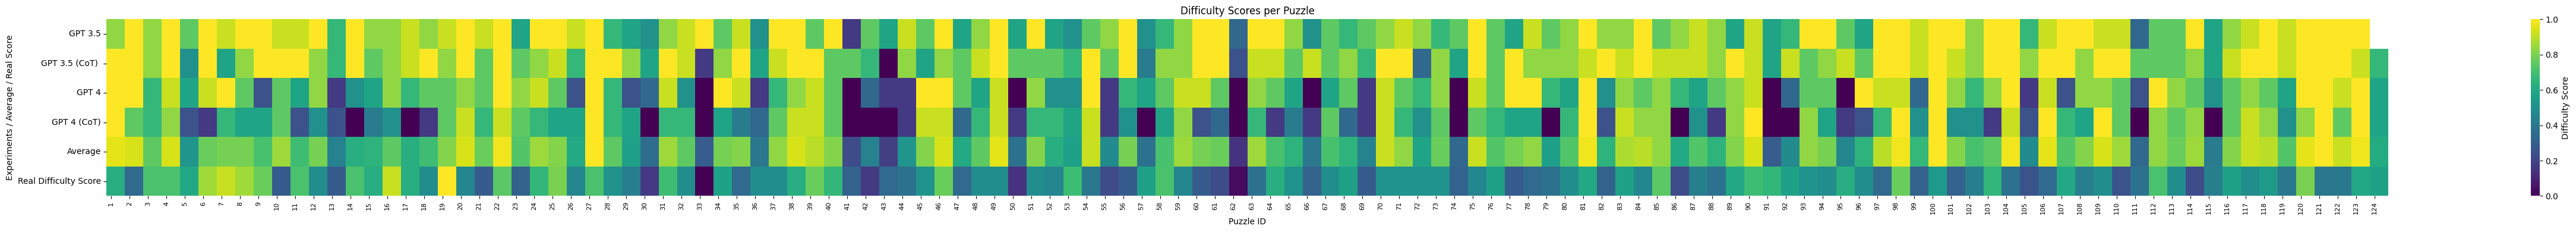

In [158]:
# Filter range for puzzles
filtered_metrics = filter_puzzles(metrics, 127)

plot_difficulty_score_heatmaps(filtered_metrics, norm_nyt_difficulties[126])

C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)


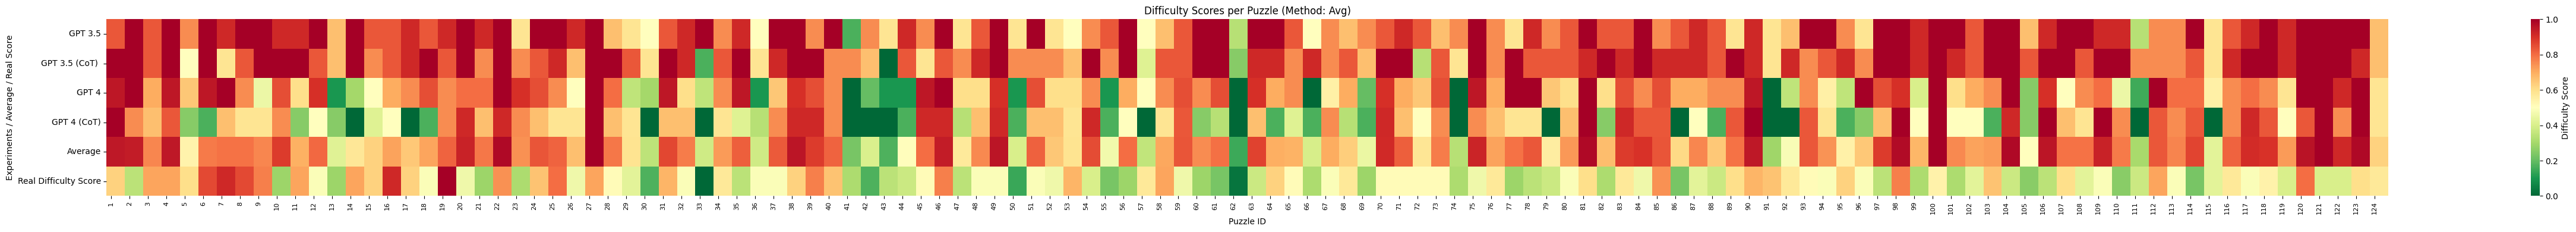

In [57]:
plot_difficulty_score_heatmaps2(filtered_metrics, norm_nyt_difficulties[126:], score_calculation_method='avg')

C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)
C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)
C:\Users\TimBits\A

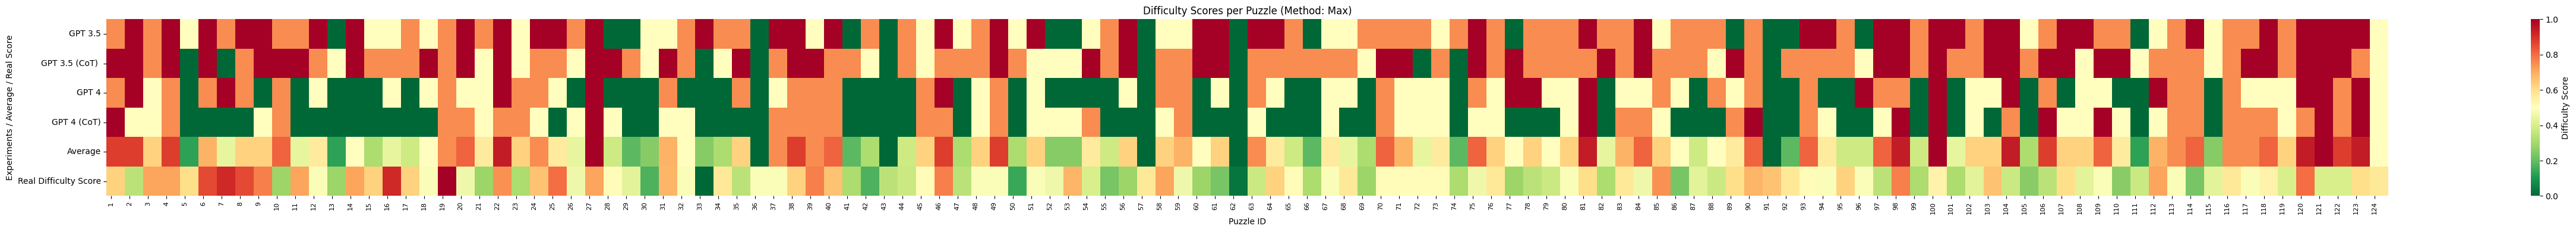

In [58]:
plot_difficulty_score_heatmaps2(filtered_metrics, norm_nyt_difficulties[126:], score_calculation_method='max')

C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)
C:\Users\TimBits\AppData\Local\Temp\ipykernel_26172\1460275647.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['difficulty_score'] = 1 - (metrics[column_name] - min_categories_solved) / (max_categories_solved - min_categories_solved)
C:\Users\TimBits\A

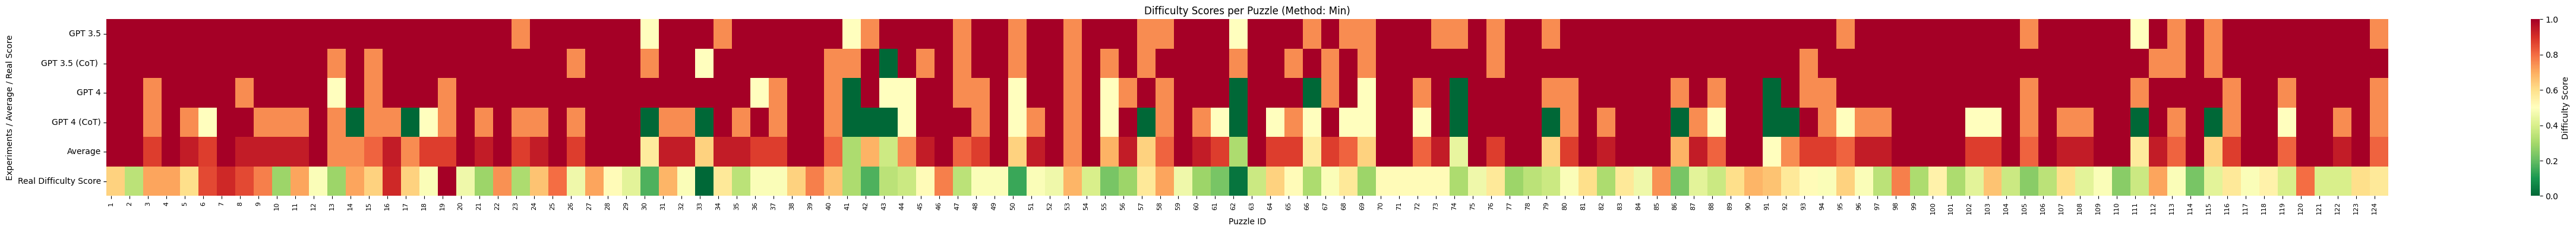

In [59]:
plot_difficulty_score_heatmaps2(filtered_metrics, norm_nyt_difficulties[126:], score_calculation_method='min')

## Get correlation with real difficulty

In [168]:
metrics = calculate_puzzle_metrics_for_experiments(difficulty_dict)
filtered_metrics = filter_puzzles(metrics, 127)
correlations = calculate_difficulty_correlation2(filtered_metrics, norm_nyt_difficulties[126:])

GPT 3.5
GPT 3.5 (CoT) 
GPT 4
GPT 4 (CoT)


In [76]:
calculate_experiment_variability(difficulty_dict)

{'GPT 3.5': {'average_variability': 0.6515067328756269,
  'median_variability': 0.5773502691896258,
  'max_variability': 2.3094010767585034},
 'GPT 3.5 (CoT) ': {'average_variability': 0.6514250902814265,
  'median_variability': 0.5773502691896258,
  'max_variability': 2.3094010767585034},
 'GPT 4': {'average_variability': 0.9430468327980415,
  'median_variability': 0.8944271909999159,
  'max_variability': 2.1908902300206643},
 'GPT 4 (CoT)': {'average_variability': 0.8024975770484211,
  'median_variability': 0.5773502691896258,
  'max_variability': 2.3094010767585034}}

In [169]:
correlations

GPT 3.5_avg_success_rate               -0.140049
GPT 3.5_ever_solved                    -0.129613
GPT 3.5_avg_categories_solved          -0.240165
GPT 3.5_max_categories_solved          -0.139172
GPT 3.5_min_categories_solved          -0.290671
GPT 3.5 (CoT) _avg_success_rate        -0.171093
GPT 3.5 (CoT) _ever_solved             -0.084280
GPT 3.5 (CoT) _avg_categories_solved   -0.238663
GPT 3.5 (CoT) _max_categories_solved   -0.159060
GPT 3.5 (CoT) _min_categories_solved   -0.243125
GPT 4_avg_success_rate                 -0.354336
GPT 4_ever_solved                      -0.262640
GPT 4_avg_categories_solved            -0.379393
GPT 4_max_categories_solved            -0.304125
GPT 4_min_categories_solved            -0.333476
GPT 4 (CoT)_avg_success_rate           -0.320932
GPT 4 (CoT)_ever_solved                -0.254925
GPT 4 (CoT)_avg_categories_solved      -0.341826
GPT 4 (CoT)_max_categories_solved      -0.265998
GPT 4 (CoT)_min_categories_solved      -0.291901
Name: real_difficult

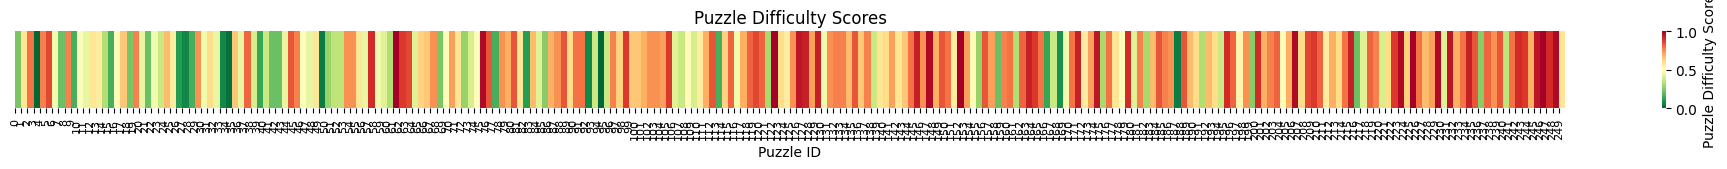

In [38]:
difficulty_scores = calc_puzzle_difficulty(difficulty_dict)
difficulty_df = difficulty_scores.to_frame().T
plt.figure(figsize=(25, 1))

ax = sns.heatmap(difficulty_df, cmap="RdYlGn_r", cbar_kws={'label': 'Puzzle Difficulty Score'})
plt.title('Puzzle Difficulty Scores')
plt.xlabel('Puzzle ID')
plt.yticks([])  # Hide the y-ticks as they are not informative in this case

# Set the x-ticks to show every puzzle index
ax.set_xticks(range(len(difficulty_df.columns)))
ax.set_xticklabels(difficulty_df.columns, rotation=90, fontsize=8)
plt.show()

# Generate Puzzle Heatmap visualization

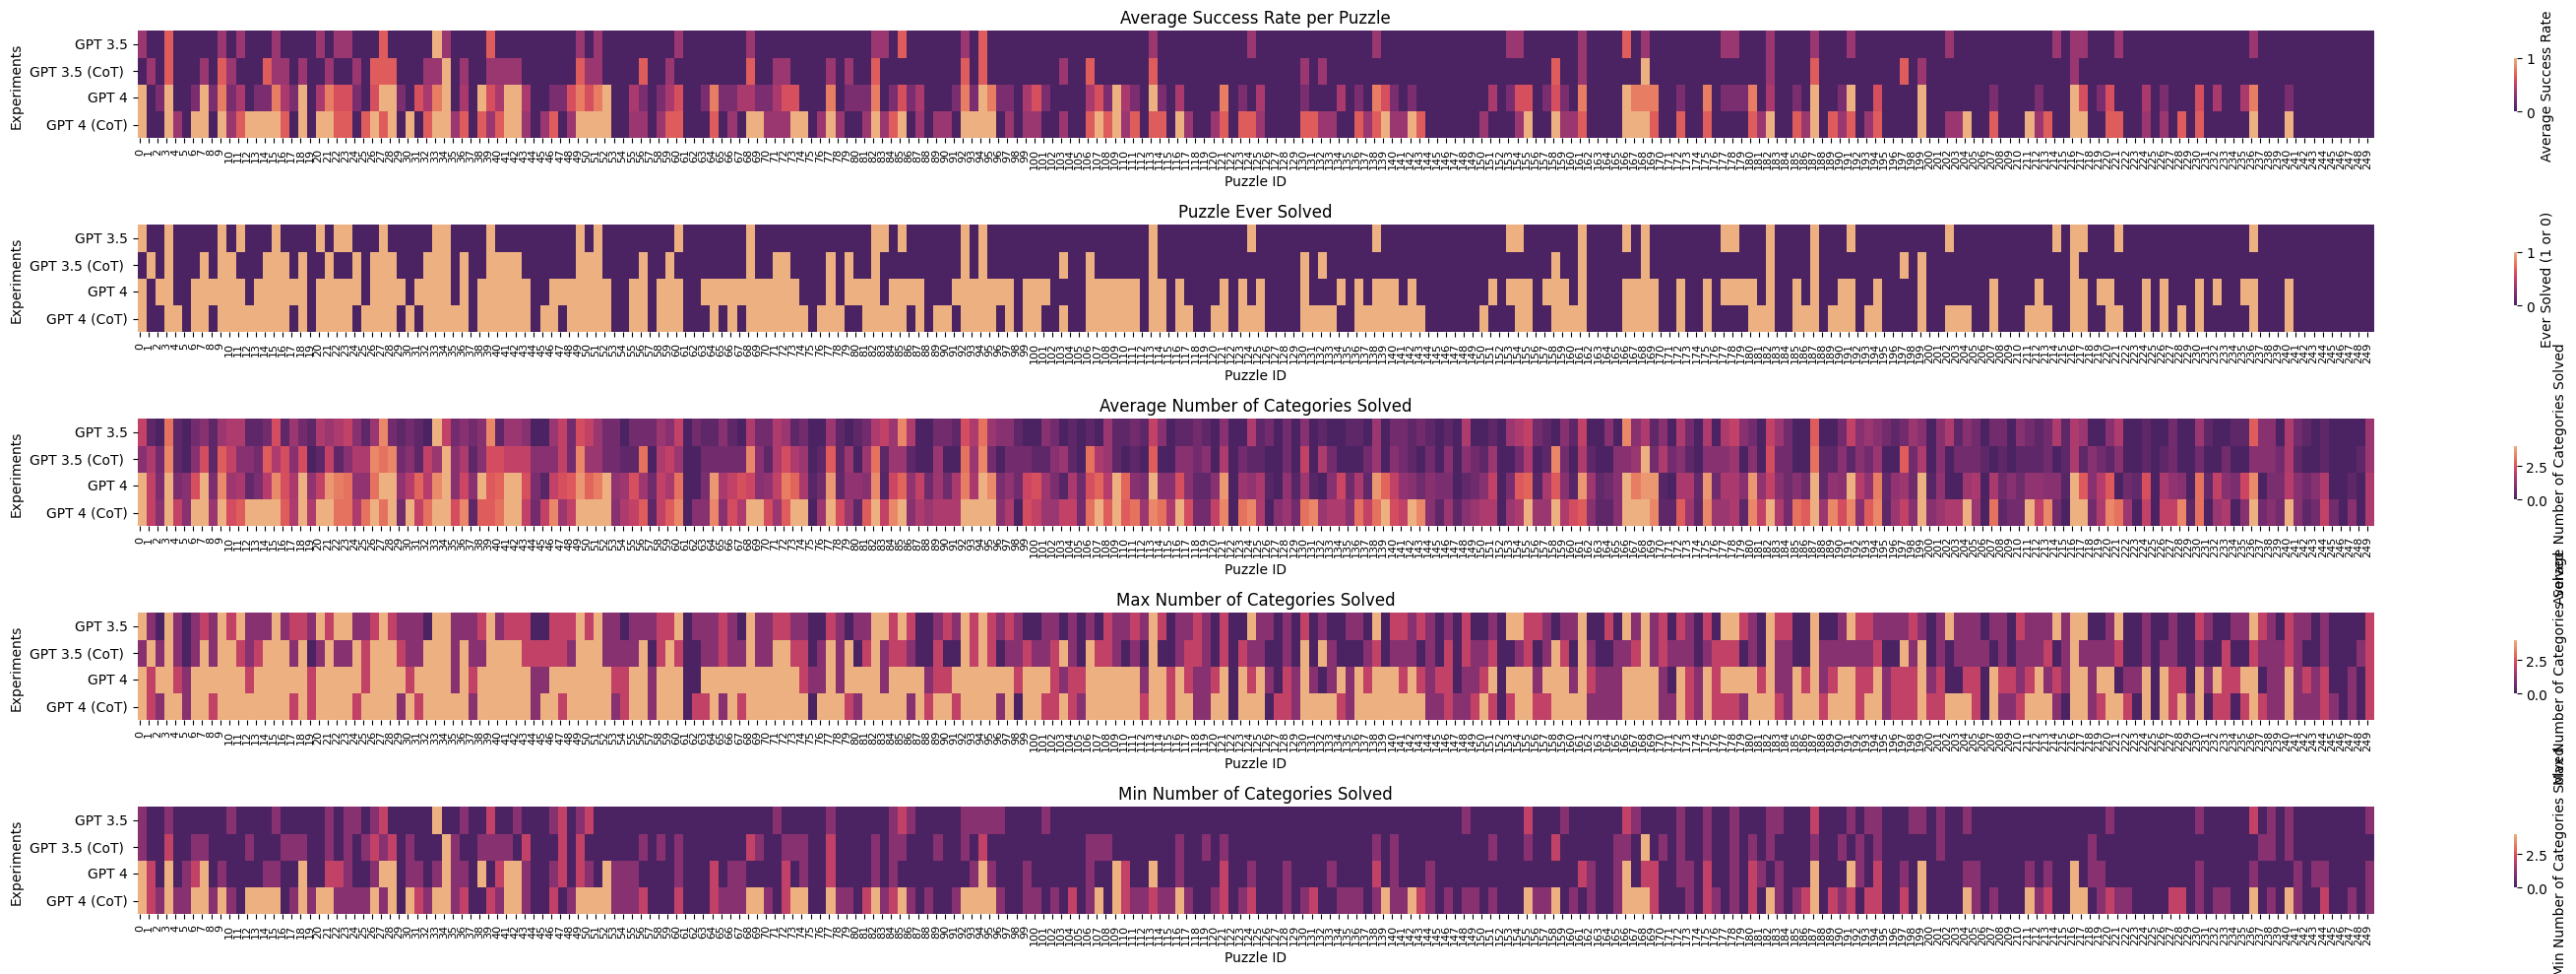

In [47]:
# heatmap_dict = {
#     '3.5-t Iterative': ['results/IterativeGPTSolver_gpt-3.5-turbo_cot-False_results.json'],
#     '4-t Iterative': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json'],
#     '4 Iterative': ['results/IterativeGPTSolver_gpt-4_cot-False_results.json'],
# }

heatmap_dict = {
    # 'BERT': ['results/SentenceTransformerBaseline_model-bert-base-nli-mean-tokens_results.json'],
    # 'RoBERTa': ['results/SentenceTransformerBaseline_model-all-roberta-large-v1_results.json'],
    # 'MiniLM': ['results/SentenceTransformerBaseline_model-all-MiniLM-L6-v2_results.json'],
    # 'MPNet': ['results/SentenceTransformerBaseline_model-all-mpnet-base-v2_results.json'],
    'GPT 3.5': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json'],
    'GPT 3.5 (CoT) ': ['results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-True_results.json'],
    'GPT 4': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json'],
    'GPT 4 (CoT)': ['results/IterativeGPTSolver_gpt-4-1106-preview_cot-True_results.json'],
}
metrics = calculate_puzzle_metrics_for_experiments(heatmap_dict)
plot_heatmaps(metrics)

# Generate success rate visualization

In [84]:
df = pd.read_json('results/OneShotGPTSolver_gpt-4-1106-preview_cot-True_results.json')
num_seeds = len(np.unique(df['seed']))
# Calculate success rates
success_yellow_count = (df['solved_yellow'] == True).sum() / 450
success_green_count = (df['solved_green'] == True).sum() / 450
success_blue_count = (df['solved_blue'] == True).sum() / 450
success_purple_count = (df['solved_purple'] == True).sum() / 450
success_overall_count = (df['solved_overall'] == True).sum() / 450
[success_yellow_count, success_green_count, success_blue_count, success_purple_count, success_overall_count]

[0.7488888888888889,
 0.6622222222222223,
 0.5155555555555555,
 0.4866666666666667,
 0.46]

[BERT] Overall: 0.024
[RoBERTa] Overall: 0.008
[MiniLM] Overall: 0.04
[MPNet] Overall: 0.06
[GPT 3.5] Overall: 0.064
[GPT 3.5 (CoT) ] Overall: 0.092
[GPT 4] Overall: 0.448
[GPT 4 (CoT)] Overall: 0.3893333333333333
[GPT 4 (CoT) Challenge] Overall: 0.058666666666666666
[GPT 3 Challenge] Overall: 0.005333333333333333


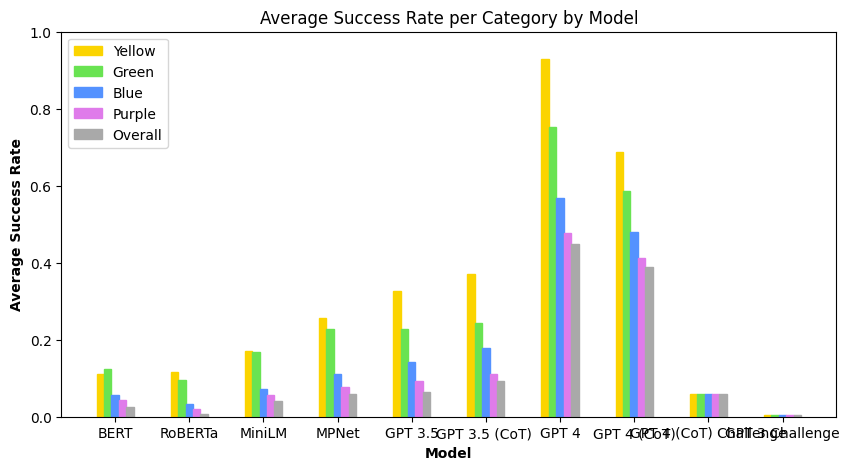

In [80]:
success_barchart_dict = {
    'BERT': 'results/SentenceTransformerBaseline_model-bert-base-nli-mean-tokens_results.json',
    'RoBERTa': 'results/SentenceTransformerBaseline_model-all-roberta-large-v1_results.json',
    'MiniLM': 'results/SentenceTransformerBaseline_model-all-MiniLM-L6-v2_results.json',
    'MPNet': 'results/SentenceTransformerBaseline_model-all-mpnet-base-v2_results.json',
    'GPT 3.5': 'results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json',
    'GPT 3.5 (CoT) ': 'results/IterativeGPTSolver_gpt-3.5-turbo-1106_cot-True_results.json',
    'GPT 4': 'results/IterativeGPTSolver_gpt-4-1106-preview_cot-False_results.json',
    'GPT 4 (CoT)': 'results/IterativeGPTSolver_gpt-4-1106-preview_cot-True_results.json',
    'GPT 4 (CoT) Challenge': 'results/OneShotGPTSolver_gpt-4-1106-preview_cot-True_results.json',
    'GPT 3 Challenge': 'results/OneShotGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json',
}

plot_puzzles_solved(success_barchart_dict)

# Generate invalids visualization

In [95]:
gpt_35_challenge = pd.read_json('results/OneShotGPTSolver_gpt-3.5-turbo-1106_cot-False_results.json')
gpt_4_challenge = pd.read_json('results/OneShotGPTSolver_gpt-4-1106-preview_cot-False_results.json')
gpt_4_cot_challenge = pd.read_json('results/OneShotGPTSolver_gpt-4-1106-preview_cot-True_results.json')

In [96]:
print(f"Average success rate for GPT-3.5 on challenge: {gpt_35_challenge['solved_overall'].mean()}")
print(f"Average success rate for GPT-4 on challenge: {gpt_4_challenge['solved_overall'][:].mean()}")
print(f"Average success rate for GPT-4 (CoT) on challenge: {gpt_4_cot_challenge['solved_overall'].mean()}")

Average success rate for GPT-3.5 on challenge: 0.017333333333333333
Average success rate for GPT-4 on challenge: 0.255659121171771
Average success rate for GPT-4 (CoT) on challenge: 0.23466666666666666


In [88]:
d1 = np.array(pd.read_json(success_barchart_dict['GPT 3.5'])['solved_overall'], dtype=int)
d2 = gpt_35_challenge['solved_overall']

t, p = scipy.stats.ttest_ind(d1, d2, equal_var=False)
print(f'GPT 3.5 vs GPT 3.5 Challenge t-test: t={t}, p={p}')

GPT 3.5 vs GPT 3.5 Challenge t-test: t=4.615884207239016, p=4.3597036556392695e-06


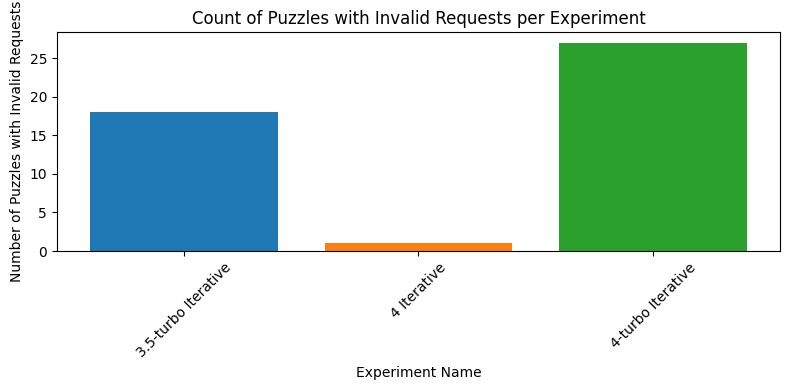

In [94]:
plot_any_invalid_requests(invalids_dict)

In [97]:
d1 = np.array(pd.read_json(success_barchart_dict['GPT 4 (CoT)'])['solved_overall'], dtype=int)[:]
d2 = gpt_4_cot_challenge['solved_overall'][:]

t, p = scipy.stats.ttest_ind(d1, d2, equal_var=False)
print(f'GPT 4 (CoT) vs GPT 4 (CoT) Challenge t-test: t={t}, p={p}')
print(f"Means: {d1.mean()}, {d2.mean()}")

GPT 4 (CoT) vs GPT 4 (CoT) Challenge t-test: t=6.552195507901181, p=7.822340535453939e-11
Means: 0.3893333333333333, 0.23466666666666666
